# ATLAS OmniFold

### Standard Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [3]:
from __future__ import absolute_import, division, print_function

from ntupleanalysis import *
import math

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

import energyflow as ef
from energyflow.archs import PFN

Using TensorFlow backend.


In [4]:
plot_setup()

In [5]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

In [6]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

### Utilities

In [7]:
def standardize(data):
    orderOfMagnitude = int(math.log(np.mean(data), 10))

    return data / (10**orderOfMagnitude)

In [8]:
# from NN (DCTR)
def reweight(model, events):
    f = model.predict(events, batch_size=1000)
    weights = f / (1. - f)
    return np.squeeze(weights)

### Load ROOT file

In [9]:
zmumu_0 = uproot.open(
    "/data0/users/bpnachman/ATLASOmniFold/GridRunOctober/ZjetOmnifold_Oct5_PowhegPythia_mc16e.root"
)['EventTree']

In [10]:
zmumu_0.show()

CutFlow                    (no streamer)              asdtype('>i4')
EventNumber                (no streamer)              asdtype('>i4')
RunNumber                  (no streamer)              asdtype('>i4')
LumiBlock                  (no streamer)              asdtype('>i4')
BCID                       (no streamer)              asdtype('>i4')
NPV                        (no streamer)              asdtype('>i4')
pass                       (no streamer)              asdtype('>i4')
truth_pass                 (no streamer)              asdtype('>i4')
initialWeight              (no streamer)              asdtype('>f4')
pileupWeight               (no streamer)              asdtype('>f4')
genWeight                  (no streamer)              asdtype('>f4')
weight                     (no streamer)              asdtype('>f4')
mu_recoSF                  (no streamer)              asdtype('>f4')
mu_isoSF                   (no streamer)              asdtype('>f4')
mu_TTVASF                  (no str

In [11]:
mybranches_0 = []
for mykey in zmumu_0.keys():
    mybranches_0 += [mykey.decode("utf-8")]

In [12]:
Events_0 = prepare_dataset_table([
    "/data0/users/bpnachman/ATLASOmniFold/GridRunOctober/ZjetOmnifold_Oct5_PowhegPythia_mc16e.root"
],
                               "EventTree",
                               branch_list=mybranches_0,
                               col_names=mybranches_0,
                               entrysteps=10000000,
                               outputype=Event_table)

Total number of events:  666677
Events in returned Object:  666677
Loading the data took  77.10571646690369  seconds


In [13]:
zmumu_unknown = uproot.open(
    "/data0/users/bpnachman/ATLASOmniFold/GridRunOctober/ZjetOmnifold_Nov6_Sherpa2210_CVetoBVeto_mc16e_LooseTTVA.root"
)['EventTree']

In [14]:
zmumu_unknown.show()

CutFlow                    (no streamer)              asdtype('>i4')
EventNumber                (no streamer)              asdtype('>i4')
RunNumber                  (no streamer)              asdtype('>i4')
LumiBlock                  (no streamer)              asdtype('>i4')
BCID                       (no streamer)              asdtype('>i4')
NPV                        (no streamer)              asdtype('>i4')
pass                       (no streamer)              asdtype('>i4')
truth_pass                 (no streamer)              asdtype('>i4')
initialWeight              (no streamer)              asdtype('>f4')
pileupWeight               (no streamer)              asdtype('>f4')
genWeight                  (no streamer)              asdtype('>f4')
weight                     (no streamer)              asdtype('>f4')
mu_recoSF                  (no streamer)              asdtype('>f4')
mu_isoSF                   (no streamer)              asdtype('>f4')
mu_TTVASF                  (no str

In [15]:
mybranches_unknown = []
for mykey in zmumu_unknown.keys():
    mybranches_unknown += [mykey.decode("utf-8")]

In [16]:
Events_unknown = prepare_dataset_table([
    "/data0/users/bpnachman/ATLASOmniFold/GridRunOctober/ZjetOmnifold_Nov6_Sherpa2210_CVetoBVeto_mc16e_LooseTTVA.root"
],
                               "EventTree",
                               branch_list=mybranches_unknown,
                               col_names=mybranches_unknown,
                               entrysteps=10000000,
                               outputype=Event_table)

Total number of events:  977568
Events in returned Object:  977568
Loading the data took  65.5518171787262  seconds


### Unpack data

In [17]:
weightsMC_0 = Events_0.events['weight']
# standardize
weightsMC_0 = weightsMC_0/np.mean(weightsMC_0)

weightsMC_unknown = Events_unknown.events['weight']
# standardize
weightsMC_unknown = weightsMC_unknown/np.mean(weightsMC_unknown)

In [18]:
# Event selection

# we should eventually properly account for events that fail one of Gen or Sim.  For now, just ignore them.

mypass_0 = (Events_0.events['m_ll'] > 0) & (Events_0.events['m_ll'] < 200) & (
    Events_0.events['truth_m_ll'] > 0) & (Events_0.events['truth_m_ll'] < 200)

mypass_unknown = (Events_unknown.events['m_ll'] > 0) & (Events_unknown.events['m_ll'] < 200) & (
    Events_unknown.events['truth_m_ll'] > 0) & (Events_unknown.events['truth_m_ll'] < 200)

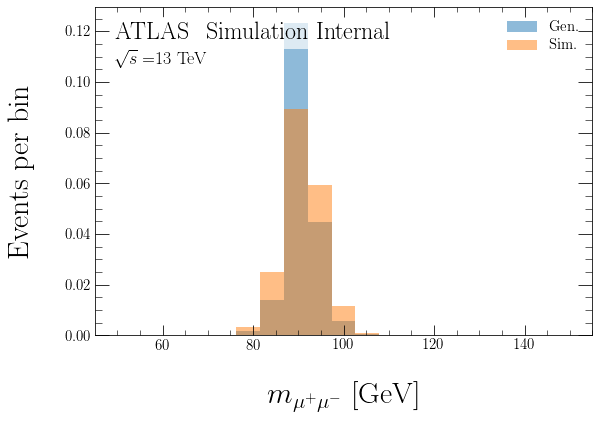

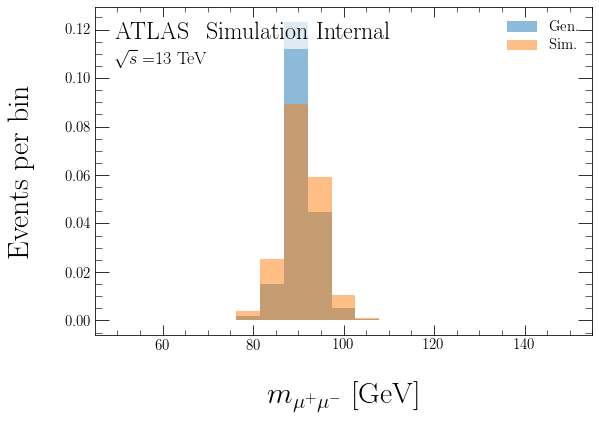

In [19]:
plt.figure()
hG, _, _ = plt.hist(Events_0.events['truth_m_ll'][mypass_0],
                    label="Gen.",
                    bins=np.linspace(50, 150, 20),
                    weights=weightsMC_0[mypass_0],
                    alpha=0.5, density=True)
hS, _, _ = plt.hist(Events_0.events['m_ll'][mypass_0],
                    label="Sim.",
                    bins=np.linspace(50, 150, 20),
                    weights=weightsMC_0[mypass_0],
                    alpha=0.5, density=True)

plt.xlabel("$m_{\mu^+\mu^-}$ [GeV]")
plt.ylabel("Events per bin")
draw_atlas_text(lines=[r'$\sqrt{s} = $13 TeV'])
plt.legend()
# plt.ylim([0, 1.5 * max(max(hG), max(hS))])
plt.show()

plt.figure()
hG, _, _ = plt.hist(Events_unknown.events['truth_m_ll'][mypass_unknown],
                    label="Gen.",
                    bins=np.linspace(50, 150, 20),
                    weights=weightsMC_unknown[mypass_unknown],
                    alpha=0.5, density=True)
hS, _, _ = plt.hist(Events_unknown.events['m_ll'][mypass_unknown],
                    label="Sim.",
                    bins=np.linspace(50, 150, 20),
                    weights=weightsMC_unknown[mypass_unknown],
                    alpha=0.5, density=True)

plt.xlabel("$m_{\mu^+\mu^-}$ [GeV]")
plt.ylabel("Events per bin")
draw_atlas_text(lines=[r'$\sqrt{s} = $13 TeV'])
plt.legend()
# plt.ylim([0, 1.5 * max(max(hG), max(hS))])
plt.show()

In [20]:
mytracks_0 = Events_0.events['truth_pT_Tracks'][mypass_0]
ntrack_0_Gen = [len(mytracks_0[i]) for i in range(len(mytracks_0))]

In [21]:
mytracks_0 = Events_0.events['pT_Tracks'][mypass_0]
ntrack_0_Sim = [len(mytracks_0[i]) for i in range(len(mytracks_0))]

In [22]:
mytracks_unknown = Events_unknown.events['truth_pT_Tracks'][mypass_unknown]
ntrack_unknown_Gen = [len(mytracks_unknown[i]) for i in range(len(mytracks_unknown))]

In [23]:
mytracks_unknown = Events_unknown.events['pT_Tracks'][mypass_unknown]
ntrack_unknown_Sim = [len(mytracks_unknown[i]) for i in range(len(mytracks_unknown))]

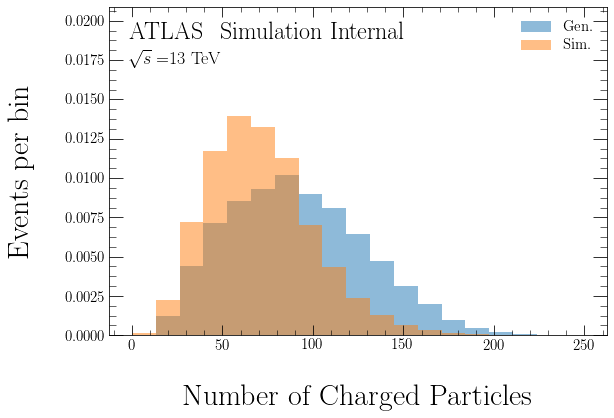

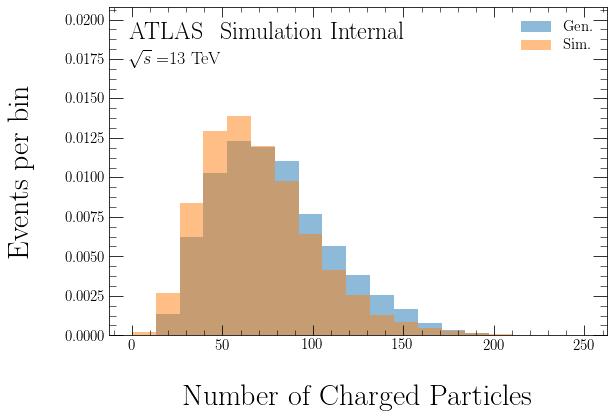

In [24]:
hG, _, _ = plt.hist(ntrack_0_Gen,
                    weights=weightsMC_0[mypass_0],
                    label="Gen.",
                    alpha=0.5,
                    density=True,
                    bins=np.linspace(0, 250, 20))
hS, _, _ = plt.hist(ntrack_0_Sim,
                    weights=weightsMC_0[mypass_0],
                    label="Sim.",
                    alpha=0.5,
                    density=True,
                    bins=np.linspace(0, 250, 20))
plt.xlabel("Number of Charged Particles")
draw_atlas_text(lines=[r'$\sqrt{s} = $13 TeV'])
plt.ylabel("Events per bin")
plt.legend()
plt.ylim([0, 1.5 * max(max(hG), max(hS))])
plt.show()

hG, _, _ = plt.hist(ntrack_unknown_Gen,
                    weights=weightsMC_unknown[mypass_unknown],
                    label="Gen.",
                    alpha=0.5,
                    density=True,
                    bins=np.linspace(0, 250, 20))
hS, _, _ = plt.hist(ntrack_unknown_Sim,
                    weights=weightsMC_unknown[mypass_unknown],
                    label="Sim.",
                    alpha=0.5,
                    density=True,
                    bins=np.linspace(0, 250, 20))
plt.xlabel("Number of Charged Particles")
draw_atlas_text(lines=[r'$\sqrt{s} = $13 TeV'])
plt.ylabel("Events per bin")
plt.legend()
plt.ylim([0, 1.5 * max(max(hG), max(hS))])
plt.show()

## UniFold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles separately.

*** As of this time, simulation with only one set of generator parameters is available. So, we will split this simulation in half, using one half as the synthetic dataset, and the other half as the unknown "natural" dataset.

### Setup Datasets

In [25]:
m_ll_0_G = Events_0.events['truth_m_ll'][mypass_0]
m_ll_0_S = Events_0.events['m_ll'][mypass_0]

m_ll_unknown_G = Events_unknown.events['truth_m_ll'][mypass_unknown]
m_ll_unknown_S = Events_unknown.events['m_ll'][mypass_unknown]

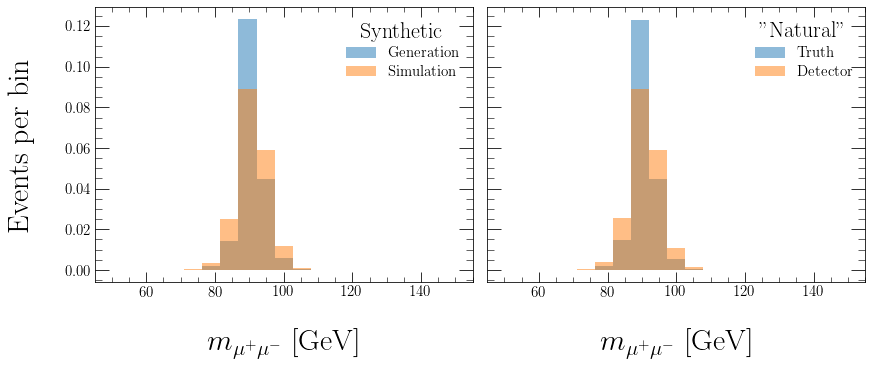

In [26]:
bins = np.linspace(50, 150, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax[0].set_ylabel('Events per bin')
hG0, _, _ = ax[0].hist(m_ll_0_G, weights=weightsMC_0[mypass_0], bins=bins, label='Generation', **plot_style_2)
hS0, _, _ = ax[0].hist(m_ll_0_S, weights=weightsMC_0[mypass_0], bins=bins, label='Simulation', **plot_style_2)
legend = ax[0].legend(title='Synthetic', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[1].hist(m_ll_unknown_G, weights=weightsMC_unknown[mypass_unknown], bins=bins, label='Truth', **plot_style_2)
hS1, _, _ = ax[1].hist(m_ll_unknown_S, weights=weightsMC_unknown[mypass_unknown], bins=bins, label='Detector', **plot_style_2)
legend = ax[1].legend(title='"Natural"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

fig.show()

In [27]:
nTracks_0_G = np.array(ntrack_0_Gen)
nTracks_0_S = np.array(ntrack_0_Sim)
nTracks_unknown_G = np.array(ntrack_unknown_Gen)
nTracks_unknown_S = np.array(ntrack_unknown_Sim)

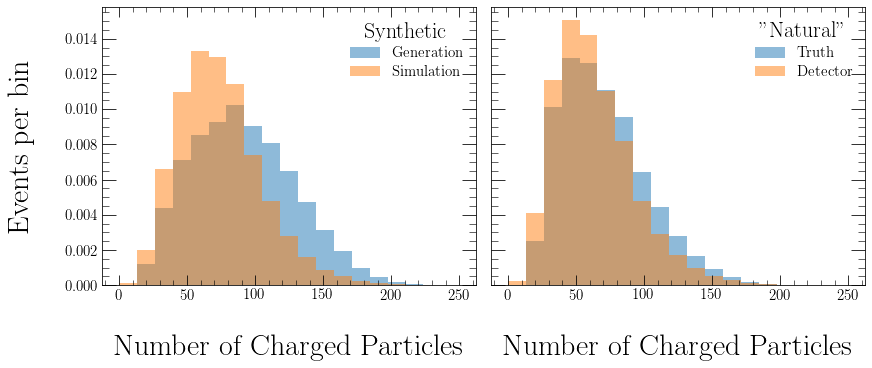

In [28]:
bins = np.linspace(0, 250, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('Number of Charged Particles')
ax[0].set_ylabel('Events per bin')
hG0, _, _ = ax[0].hist(nTracks_0_G,
                       #weights=weightsMC_0[mypass_0],
                       bins=bins,
                       label='Generation',
                       **plot_style_2)
hS0, _, _ = ax[0].hist(nTracks_0_S,
                       #weights=weightsMC_0[mypass_0],
                       bins=bins,
                       label='Simulation',
                       **plot_style_2)
legend = ax[0].legend(title='Synthetic', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1].hist(nTracks_unknown_G,
                       #weights=weightsMC_unknown[mypass_unknown],
                       bins=bins,
                       label='Truth',
                       **plot_style_2)
hS1, _, _ = ax[1].hist(nTracks_unknown_S,
                       #weights=weightsMC_unknown[mypass_unknown],
                       bins=bins,
                       label='Detector',
                       **plot_style_2)
legend = ax[1].legend(title='"Natural"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

fig.show()

### Define UniFold Algorithm

In [29]:
"""    Arguments:
                            
        iterations: number of iterations (integer)
        
        theta_0_G: synthetic generation-level observable as Numpy array
                    
        theta_0_S: synthetic simulation-level observable as Numpy array
                    
        theta_unknown_S: "natural" (unknown) simulation-level observable 
                            to be unfolded as Numpy arrays
                            
        weightsMC_0: (optional) initial MC generator weights for synthetic sample
        
        weightsMC_unknown: (optional) initial MC generator weights for natural sample
        
        Returns:
        
        weights: A Numpy array of weights to reweight distribution of 
                    theta_0_G to the unfolded distribution of theta_unknown_S
        
        model: The model used to calculate those weights
"""


def unifold(iterations,
            theta_0_G,
            theta_0_S,
            theta_unknown_S,
            weightsMC_0=None,
            weightsMC_unknown=None):
    
    if weightsMC_0 is None:
        weightsMC_0 = np.ones(len(theta_0_G)) 
        
    if weightsMC_unknown is None:
        weightsMC_unknown = np.ones(len(theta_unknown_S))

    labels_0 = np.zeros(len(theta_0_G))
    labels_unknown = np.ones(len(theta_unknown_S))

    xvals_1 = np.concatenate((theta_0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels_0, labels_unknown))

    xvals_2 = np.concatenate((theta_0_G, theta_0_G))
    yvals_2 = np.concatenate((labels_0, (labels_0+1.)))

    weights = np.empty(shape=(iterations, 2, len(theta_0_G)))
    # shape = (iteration, step, event)

    weights_pull = weightsMC_0
    weights_push = weightsMC_0

    inputs = Input((1, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                                  verbose=1,
                                  restore_best_weights=True)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data
        print("STEP 1\n")

        weights_1 = np.concatenate((weights_push, weightsMC_unknown))
        # actual weights for Sim., ones for Data

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_1,
                  Y_train_1,
                  sample_weight=w_train_1,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_1, Y_test_1, w_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(model, theta_0_S)
        weights[i, :1, :] = weights_pull

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((weightsMC_0, weights_pull))
        # ones for Gen., actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  sample_weight=w_train_2,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_2, Y_test_2, w_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = weightsMC_0 * reweight(model, theta_0_G)
        weights[i, 1:2, :] = weights_push

    return weights, model

### Unfold $m_{\mu^+\mu^-}$

In [30]:
# simple / 100. standardization s.t. data is of order ~1

weights, _ = unifold(iterations=3,
                     theta_0_G=m_ll_0_G / 100.,
                     theta_0_S=m_ll_0_S / 100.,
                     weightsMC_0=weightsMC_0[mypass_0],
                     theta_unknown_S=m_ll_unknown_S / 100.,
                     weightsMC_unknown=weightsMC_unknown[mypass_unknown])





ITERATION: 1

STEP 1



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1143892 samples, validate on 381298 samples
Epoch 1/200





1143892/1143892 [==============================] - 3s 3us/step - loss: 0.6842 - acc: 0.5924 - val_loss: 0.6892 - val_acc: 0.5912
Epoch 2/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6840 - acc: 0.5924 - val_loss: 0.6893 - val_acc: 0.5912
Epoch 3/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6840 - acc: 0.5924 - val_loss: 0.6894 - val_acc: 0.5912
Epoch 4/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6840 - acc: 0.5924 - val_loss: 0.6893 - val_acc: 0.5912
Epoch 5/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6841 - acc: 0.5924 - val_loss: 0.6900 - val_acc: 0.5912
Epoch 6/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6842 - acc: 0.5924 - val_lo

933165/933165 [==============================] - 2s 2us/step - loss: 0.8583 - acc: 0.4999 - val_loss: 0.8576 - val_acc: 0.5004
Epoch 9/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8583 - acc: 0.4999 - val_loss: 0.8576 - val_acc: 0.5004
Epoch 10/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8583 - acc: 0.4999 - val_loss: 0.8577 - val_acc: 0.5004
Epoch 11/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8583 - acc: 0.4999 - val_loss: 0.8576 - val_acc: 0.5004
Epoch 12/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8583 - acc: 0.4999 - val_loss: 0.8576 - val_acc: 0.5004
Epoch 13/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8583 - acc: 0.4999 - val_loss: 0.8576 - val_acc: 0.5004
Epoch 14/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8583 - acc: 0.4999 - val_loss: 0.8576 - val_acc: 0.5004
Epoch 15/200
933165/933165 [======

933165/933165 [==============================] - 2s 2us/step - loss: 0.8596 - acc: 0.5004 - val_loss: 0.8598 - val_acc: 0.4989
Epoch 35/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8596 - acc: 0.5004 - val_loss: 0.8598 - val_acc: 0.4989
Epoch 36/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8596 - acc: 0.5004 - val_loss: 0.8598 - val_acc: 0.4989
Epoch 37/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8596 - acc: 0.5004 - val_loss: 0.8598 - val_acc: 0.4989
Epoch 38/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8596 - acc: 0.5004 - val_loss: 0.8598 - val_acc: 0.4989
Epoch 39/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8596 - acc: 0.5004 - val_loss: 0.8598 - val_acc: 0.4989
Epoch 40/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8596 - acc: 0.5004 - val_loss: 0.8599 - val_acc: 0.4989
Epoch 41/200
933165/933165 [=====

ITERATION 1:


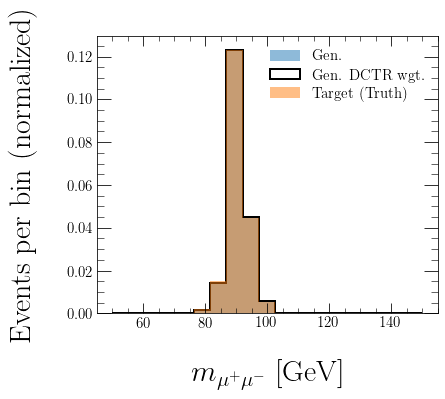

ITERATION 2:


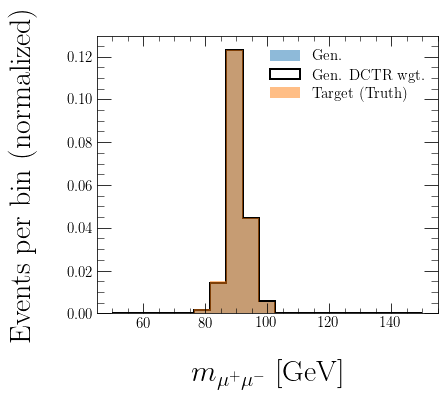

ITERATION 3:


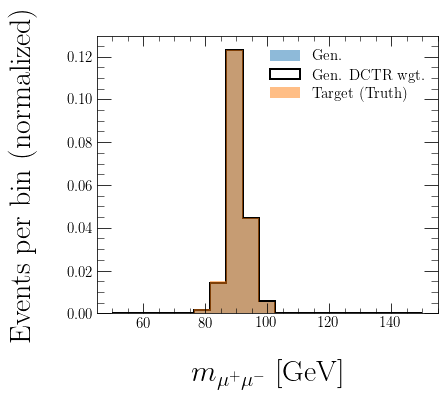

In [31]:
bins = np.linspace(50, 150, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(m_ll_0_G,
                     weights=weightsMC_0[mypass_0],
                     bins=bins,
                     label=r'Gen.',
                     **plot_style_2)

    hist1 = plt.hist(m_ll_0_G,
                     bins=bins,
                     label='Gen. DCTR wgt.',
                     weights=weights[i, 1, :],
                     **plot_style_1)
    hist2 = plt.hist(m_ll_unknown_G,
                     weights=weightsMC_unknown[mypass_unknown],
                     bins=bins,
                     label=r'Target (Truth)',
                     **plot_style_2)
    plt.legend(frameon=False)
    plt.xlabel(r"$m_{\mu^+\mu^-}$ [GeV]")
    plt.ylabel("Events per bin (normalized)")
    plt.show()

### Unfold Number of Charged Particles

In [32]:
# simple / 100. standardization s.t. data is of order ~1

weights, _ = unifold(iterations=5,
                     theta_0_G=nTracks_0_G / 100.,
                     theta_0_S=nTracks_0_S / 100.,
                     weightsMC_0=weightsMC_0[mypass_0],
                     theta_unknown_S=nTracks_unknown_S / 100.,
                     weightsMC_unknown=weightsMC_unknown[mypass_unknown])


ITERATION: 1

STEP 1

Train on 1143892 samples, validate on 381298 samples
Epoch 1/200
1143892/1143892 [==============================] - 4s 3us/step - loss: 0.6863 - acc: 0.5921 - val_loss: 0.6875 - val_acc: 0.5922
Epoch 2/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6839 - acc: 0.5921 - val_loss: 0.6865 - val_acc: 0.5922
Epoch 3/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6833 - acc: 0.5921 - val_loss: 0.6866 - val_acc: 0.5922
Epoch 4/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6832 - acc: 0.5921 - val_loss: 0.6863 - val_acc: 0.5922
Epoch 5/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6831 - acc: 0.5921 - val_loss: 0.6862 - val_acc: 0.5922
Epoch 6/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6832 - acc: 0.5921 - val_loss: 0.6863 - val_acc: 0.5922
Epoch 7/200
1143892/1143892 [==============================] - 2s 2us/step - l

1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8314 - acc: 0.5670 - val_loss: 0.8300 - val_acc: 0.5838
Epoch 21/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8314 - acc: 0.5672 - val_loss: 0.8299 - val_acc: 0.5746
Epoch 22/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8314 - acc: 0.5716 - val_loss: 0.8299 - val_acc: 0.5627
Epoch 23/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8314 - acc: 0.5695 - val_loss: 0.8298 - val_acc: 0.5611
Restoring model weights from the end of the best epoch
Epoch 00023: early stopping

STEP 2

Train on 933165 samples, validate on 311055 samples
Epoch 1/200
933165/933165 [==============================] - 3s 4us/step - loss: 0.8606 - acc: 0.5002 - val_loss: 0.8563 - val_acc: 0.4994
Epoch 2/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8568 - acc: 0.5002 - val_loss: 0.8563 - val_acc: 0.4994
Epoch 3/200
933165/9331

933165/933165 [==============================] - 4s 4us/step - loss: 0.8597 - acc: 0.4994 - val_loss: 0.8549 - val_acc: 0.5015
Epoch 2/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8557 - acc: 0.4995 - val_loss: 0.8550 - val_acc: 0.5015
Epoch 3/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8557 - acc: 0.4995 - val_loss: 0.8550 - val_acc: 0.5015
Epoch 4/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8557 - acc: 0.4995 - val_loss: 0.8549 - val_acc: 0.5015
Epoch 5/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8557 - acc: 0.4995 - val_loss: 0.8550 - val_acc: 0.5015
Epoch 6/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8557 - acc: 0.4995 - val_loss: 0.8549 - val_acc: 0.5015
Epoch 7/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8557 - acc: 0.4995 - val_loss: 0.8550 - val_acc: 0.5015
Epoch 8/200
933165/933165 [============

Epoch 44/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8355 - acc: 0.5237 - val_loss: 0.8343 - val_acc: 0.5421
Epoch 45/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8354 - acc: 0.5163 - val_loss: 0.8344 - val_acc: 0.4964
Epoch 46/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8354 - acc: 0.5163 - val_loss: 0.8343 - val_acc: 0.5313
Restoring model weights from the end of the best epoch
Epoch 00046: early stopping

STEP 2

Train on 933165 samples, validate on 311055 samples
Epoch 1/200
933165/933165 [==============================] - 4s 4us/step - loss: 0.8589 - acc: 0.5003 - val_loss: 0.8533 - val_acc: 0.4997
Epoch 2/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8531 - acc: 0.5001 - val_loss: 0.8532 - val_acc: 0.4997
Epoch 3/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8531 - acc: 0.5001 - val_loss: 0.8532 - val_acc: 0.4997
Epoch 4/200
9

ITERATION 1:


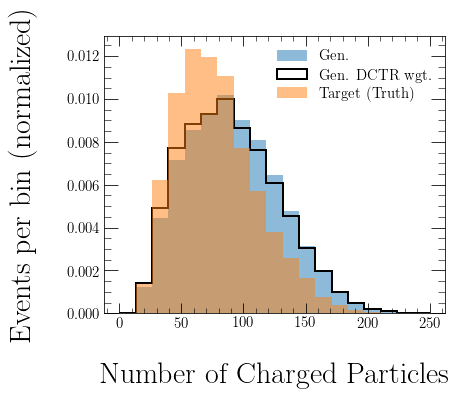

ITERATION 2:


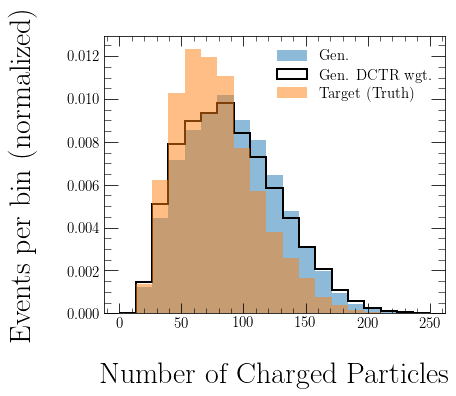

ITERATION 3:


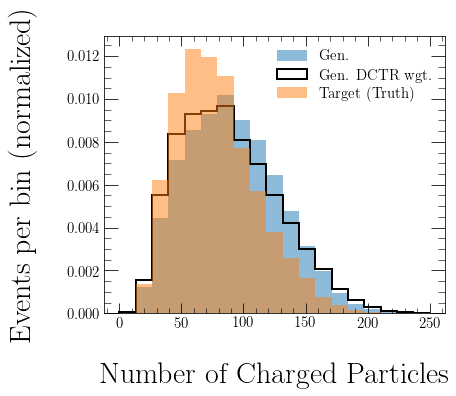

ITERATION 4:


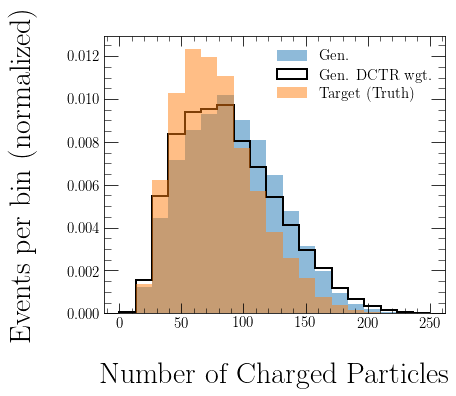

ITERATION 5:


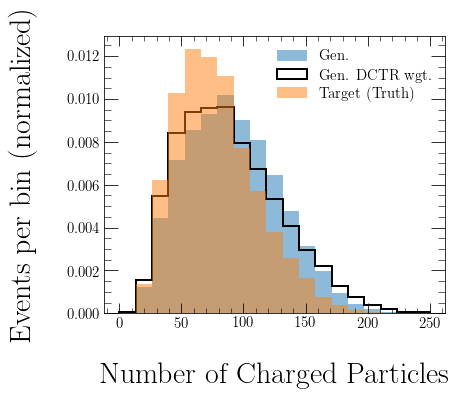

In [33]:
bins = np.linspace(0, 250, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(nTracks_0_G, weights=weightsMC_0[mypass_0], bins=bins, label=r'Gen.', **plot_style_2)

    hist1 = plt.hist(nTracks_0_G,
                     bins=bins,
                     label='Gen. DCTR wgt.',
                     weights=weights[i, 1, :],
                     **plot_style_1)
    hist2 = plt.hist(nTracks_unknown_G,
                     weights=weightsMC_unknown[mypass_unknown],
                     bins=bins,
                     label=r'Target (Truth)',
                     **plot_style_2)
    plt.legend(frameon=False)
    plt.xlabel(r"Number of Charged Particles")
    plt.ylabel("Events per bin (normalized)")
    plt.show()

## Multifold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles simultaneously.

*** As of this time, simulation with only one set of generator parameters is available. So, we will split this simulation in half, using one half as the synthetic dataset, and the other half as the unknown "natural" dataset.

In [34]:
K.clear_session()

### Setup datasets

In [35]:
m_ll_0_G = Events_0.events['truth_m_ll'][mypass_0]
m_ll_0_S = Events_0.events['m_ll'][mypass_0]

m_ll_unknown_G = Events_unknown.events['truth_m_ll'][mypass_unknown]
m_ll_unknown_S = Events_unknown.events['m_ll'][mypass_unknown]

nTracks_0_G = np.array(ntrack_0_Gen)
nTracks_0_S = np.array(ntrack_0_Sim)

nTracks_unknown_G = np.array(ntrack_unknown_Gen)
nTracks_unknown_S = np.array(ntrack_unknown_Sim)

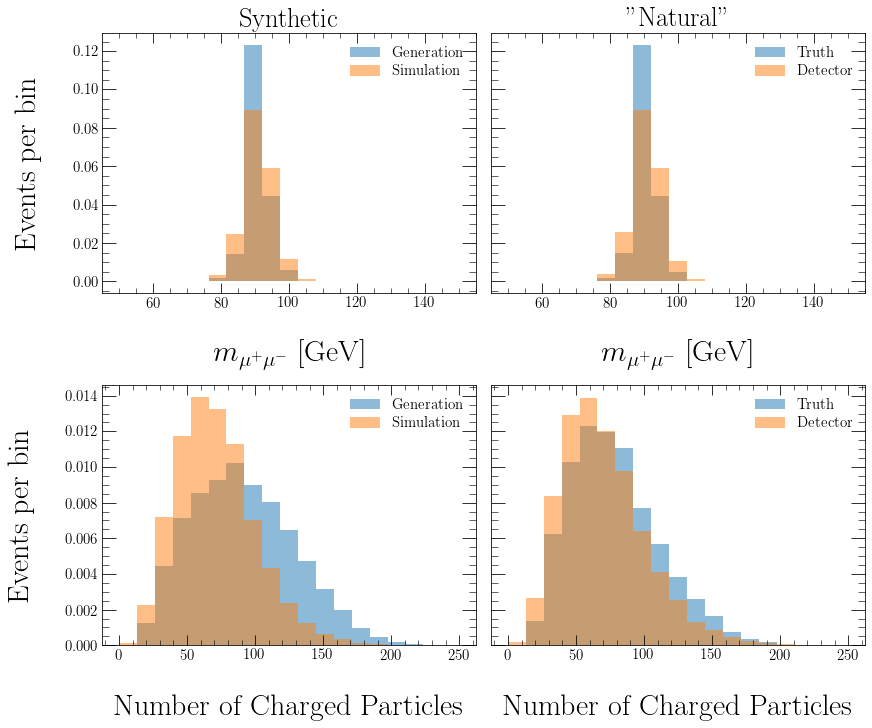

In [36]:
fig, ax = plt.subplots(2,
                       2,
                       figsize=(12, 10),
                       constrained_layout=True,
                       sharey='row')

bins = np.linspace(50, 150, 20)

ax[0, 0].set_title('Synthetic')
ax[0, 0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax[0, 0].set_ylabel('Events per bin')
hG0, _, _ = ax[0, 0].hist(m_ll_0_G,
                          weights=weightsMC_0[mypass_0],
                          bins=bins,
                          label='Generation',
                          **plot_style_2)
hS0, _, _ = ax[0, 0].hist(m_ll_0_S,
                          weights=weightsMC_0[mypass_0],
                          bins=bins,
                          label='Simulation',
                          **plot_style_2)
legend = ax[0, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[0, 1].set_title('"Natural"')
ax[0, 1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[0, 1].hist(m_ll_unknown_G,
                          weights=weightsMC_unknown[mypass_unknown],
                          bins=bins,
                          label='Truth',
                          **plot_style_2)
hS1, _, _ = ax[0, 1].hist(m_ll_unknown_S,
                          weights=weightsMC_unknown[mypass_unknown],
                          bins=bins,
                          label='Detector',
                          **plot_style_2)
legend = ax[0, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

bins = np.linspace(0, 250, 20)

ax[1, 0].set_xlabel('Number of Charged Particles')
ax[1, 0].set_ylabel('Events per bin')
hG0, _, _ = ax[1, 0].hist(nTracks_0_G,
                          weights=weightsMC_0[mypass_0],
                          bins=bins,
                          label='Generation',
                          **plot_style_2)
hS0, _, _ = ax[1, 0].hist(nTracks_0_S,
                          weights=weightsMC_0[mypass_0],
                          bins=bins,
                          label='Simulation',
                          **plot_style_2)
legend = ax[1, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1, 1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1, 1].hist(nTracks_unknown_G,
                          weights=weightsMC_unknown[mypass_unknown],
                          bins=bins,
                          label='Truth',
                          **plot_style_2)
hS1, _, _ = ax[1, 1].hist(nTracks_unknown_S,
                          weights=weightsMC_unknown[mypass_unknown],
                          bins=bins,
                          label='Detector',
                          **plot_style_2)
legend = ax[1, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

fig.show()

### Define MultiFold Algorithm

In [37]:
# Input multiple observables as tuple or list (i.e. theta_0_G = (obs_1, obs_2, ...))
"""    Arguments:
        num_observables: number of observables to 
                            simultaneously unfold (integer)
                            
        iterations: number of iterations (integer)
        
        theta_0_G: tuple or list of synthetic 
                    generation-level observables as Numpy arrays
                    
        theta_0_S: tuple or list of synthetic 
                    simulation-level observables as Numpy arrays
                    
        theta_unknown_S: tuple or list of "natural" 
                            (unknown) simulation-level observables 
                            to be unfolded as Numpy arrays
        
        weightsMC_0: (optional) initial MC generator weights for synthetic sample
        
        weightsMC_unknown: (optional) initial MC generator weights for natural sample
        
        Returns:
        
        weights: A Numpy array of weights to reweight distribution of 
                    theta_0_G to the unfolded distribution of theta_unknown_S
        
        model: The model used to calculate those weights
"""


def multifold(num_observables,
              iterations,
              theta_0_G,
              theta_0_S,
              theta_unknown_S,
              weightsMC_0=None,
              weightsMC_unknown=None):
    
    if weightsMC_0 is None:
        weightsMC_0 = np.ones(len(theta_0_G)) 
        
    if weightsMC_unknown is None:
        weightsMC_unknown = np.ones(len(theta_unknown_S))

    theta_0_G = np.stack(theta_0_G, axis=1)
    theta_0_S = np.stack(theta_0_S, axis=1)
    theta_unknown_S = np.stack(theta_unknown_S, axis=1)

    labels_0 = np.zeros(len(theta_0_G))
    labels_unknown = np.ones(len(theta_unknown_S))

    xvals_1 = np.concatenate((theta_0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels_0, labels_unknown))

    xvals_2 = np.concatenate((theta_0_G, theta_0_G))
    yvals_2 = np.concatenate((labels_0, (labels_0+1.)))

    weights = np.empty(shape=(iterations, 2, len(theta_0_G)))
    # shape = (iteration, step, event)

    weights_pull = np.ones(len(theta_0_S))
    weights_push = np.ones(len(theta_0_G))

    inputs = Input((num_observables, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                                  verbose=1,
                                  restore_best_weights=True)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data
        print("STEP 1\n")

        weights_1 = np.concatenate(
            (weights_push, np.ones(len(theta_unknown_S))))
        # actual weights for Sim., ones for Data

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_1,
                  Y_train_1,
                  sample_weight=w_train_1,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_1, Y_test_1, w_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(model, theta_0_S)
        weights[i, :1, :] = weights_pull

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((np.ones(len(theta_0_G)), weights_pull))
        # ones for Gen., actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  sample_weight=w_train_2,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_2, Y_test_2, w_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = weightsMC_0 * reweight(model, theta_0_G)
        weights[i, 1:2, :] = weights_push

    return weights, model

### Unfold $m_{\mu^+\mu^-}$ and Number of Charged Particles Simultaneously

In [38]:
num_observables = 2

# simple / 100. standardization s.t. data is of order ~1

weights, _ = multifold(num_observables=num_observables,
                       iterations=5,
                       theta_0_G=(m_ll_0_G / 100., nTracks_0_G / 100.),
                       theta_0_S=(m_ll_0_S / 100., nTracks_0_S / 100.),
                       weightsMC_0=weightsMC_0[mypass_0],
                       theta_unknown_S=(m_ll_unknown_S / 100.,
                                        nTracks_unknown_S / 100.),
                       weightsMC_unknown=weightsMC_unknown[mypass_unknown])


ITERATION: 1

STEP 1

Train on 1143892 samples, validate on 381298 samples
Epoch 1/200
1143892/1143892 [==============================] - 3s 3us/step - loss: 0.6630 - acc: 0.5989 - val_loss: 0.6589 - val_acc: 0.6021
Epoch 2/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6596 - acc: 0.6016 - val_loss: 0.6588 - val_acc: 0.6023
Epoch 3/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6596 - acc: 0.6016 - val_loss: 0.6587 - val_acc: 0.6025
Epoch 4/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6595 - acc: 0.6019 - val_loss: 0.6589 - val_acc: 0.6023
Epoch 5/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6594 - acc: 0.6019 - val_loss: 0.6586 - val_acc: 0.6032
Epoch 6/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.6593 - acc: 0.6025 - val_loss: 0.6583 - val_acc: 0.6036
Epoch 7/200
1143892/1143892 [==============================] - 2s 2us/step - l

933165/933165 [==============================] - 2s 2us/step - loss: 0.8207 - acc: 0.4998 - val_loss: 0.8193 - val_acc: 0.5001
Epoch 14/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8207 - acc: 0.4998 - val_loss: 0.8194 - val_acc: 0.4999
Epoch 15/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8207 - acc: 0.4997 - val_loss: 0.8195 - val_acc: 0.5003
Epoch 16/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8209 - acc: 0.5001 - val_loss: 0.8195 - val_acc: 0.4998
Epoch 17/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8208 - acc: 0.4998 - val_loss: 0.8197 - val_acc: 0.5002
Epoch 18/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8207 - acc: 0.5000 - val_loss: 0.8195 - val_acc: 0.5002
Epoch 19/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8207 - acc: 0.5002 - val_loss: 0.8194 - val_acc: 0.5001
Epoch 20/200
933165/933165 [=====

933165/933165 [==============================] - 2s 2us/step - loss: 0.8187 - acc: 0.4997 - val_loss: 0.8208 - val_acc: 0.5006
Epoch 3/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8184 - acc: 0.4999 - val_loss: 0.8201 - val_acc: 0.5006
Epoch 4/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8183 - acc: 0.4996 - val_loss: 0.8201 - val_acc: 0.5006
Epoch 5/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8183 - acc: 0.4995 - val_loss: 0.8202 - val_acc: 0.5003
Epoch 6/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8183 - acc: 0.4999 - val_loss: 0.8199 - val_acc: 0.5006
Epoch 7/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8184 - acc: 0.4997 - val_loss: 0.8202 - val_acc: 0.5006
Epoch 8/200
933165/933165 [==============================] - 2s 2us/step - loss: 0.8183 - acc: 0.4998 - val_loss: 0.8200 - val_acc: 0.5008
Epoch 9/200
933165/933165 [============

1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8316 - acc: 0.5335 - val_loss: 0.8320 - val_acc: 0.5301
Epoch 34/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8317 - acc: 0.5337 - val_loss: 0.8320 - val_acc: 0.5300
Epoch 35/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8316 - acc: 0.5340 - val_loss: 0.8320 - val_acc: 0.5567
Epoch 36/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8316 - acc: 0.5326 - val_loss: 0.8321 - val_acc: 0.5526
Epoch 37/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8316 - acc: 0.5372 - val_loss: 0.8320 - val_acc: 0.5272
Epoch 38/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8316 - acc: 0.5341 - val_loss: 0.8320 - val_acc: 0.5123
Epoch 39/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8317 - acc: 0.5324 - val_loss: 0.8322 - val_acc: 0.5470
Epoch 40/200
114389

1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8273 - acc: 0.5235 - val_loss: 0.8268 - val_acc: 0.5241
Epoch 22/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8273 - acc: 0.5266 - val_loss: 0.8266 - val_acc: 0.5388
Epoch 23/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8272 - acc: 0.5258 - val_loss: 0.8267 - val_acc: 0.5011
Epoch 24/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8273 - acc: 0.5220 - val_loss: 0.8265 - val_acc: 0.5208
Epoch 25/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8273 - acc: 0.5249 - val_loss: 0.8265 - val_acc: 0.5392
Epoch 26/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8273 - acc: 0.5248 - val_loss: 0.8267 - val_acc: 0.5212
Epoch 27/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8273 - acc: 0.5235 - val_loss: 0.8267 - val_acc: 0.5408
Epoch 28/200
114389

1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8295 - acc: 0.5075 - val_loss: 0.8311 - val_acc: 0.5272
Epoch 24/200
1143892/1143892 [==============================] - 3s 2us/step - loss: 0.8296 - acc: 0.5036 - val_loss: 0.8315 - val_acc: 0.5507
Epoch 25/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8295 - acc: 0.5057 - val_loss: 0.8313 - val_acc: 0.4965
Epoch 26/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8295 - acc: 0.5127 - val_loss: 0.8311 - val_acc: 0.4872
Epoch 27/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8295 - acc: 0.5019 - val_loss: 0.8312 - val_acc: 0.5103
Epoch 28/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8295 - acc: 0.5079 - val_loss: 0.8311 - val_acc: 0.4805
Epoch 29/200
1143892/1143892 [==============================] - 2s 2us/step - loss: 0.8296 - acc: 0.5059 - val_loss: 0.8311 - val_acc: 0.5381
Epoch 30/200
114389

ITERATION: 1


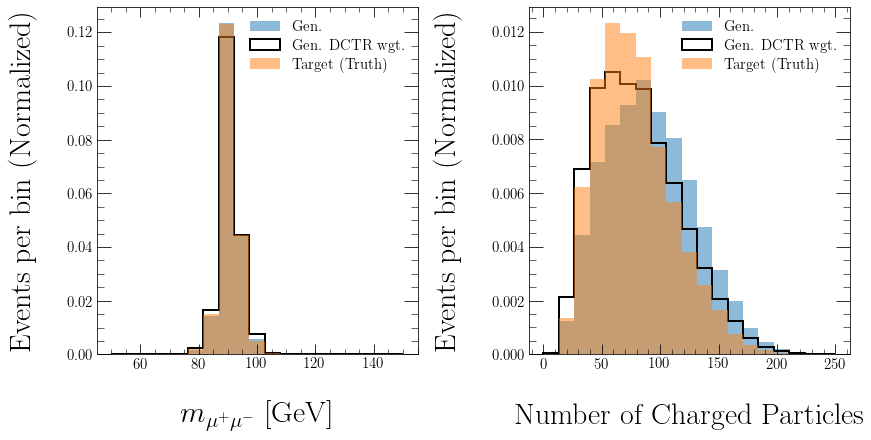

ITERATION: 2


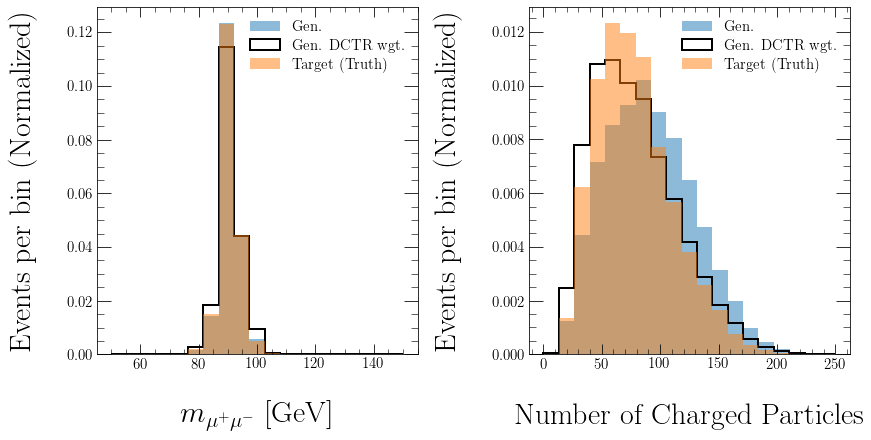

ITERATION: 3


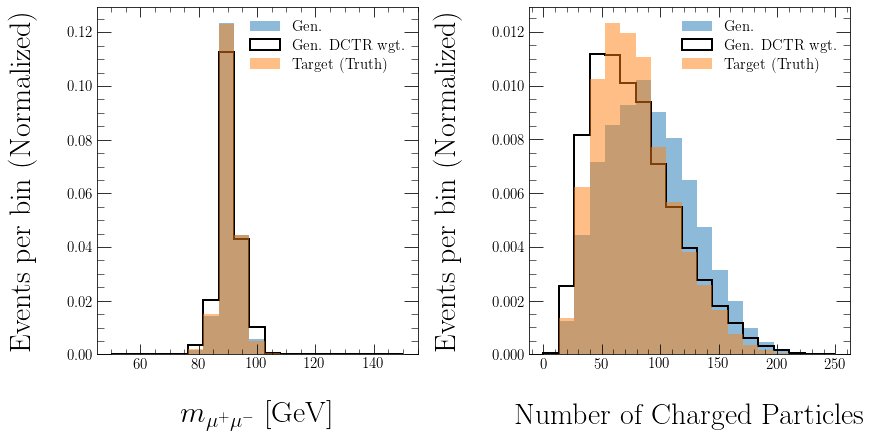

ITERATION: 4


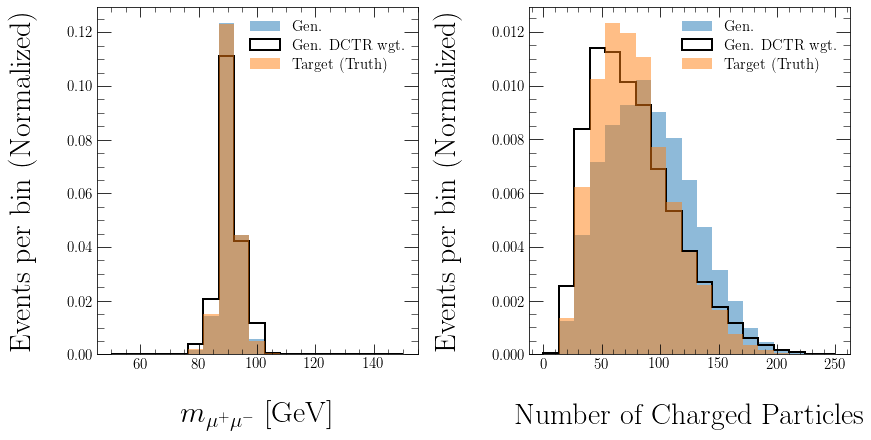

ITERATION: 5


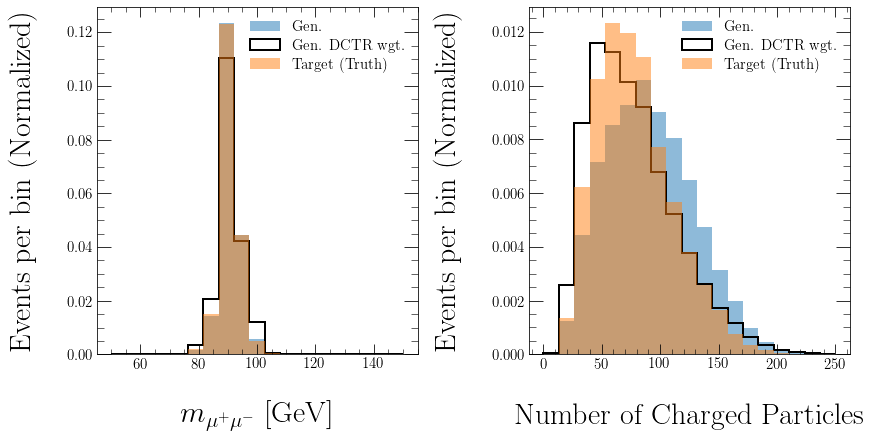

In [39]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(50, 150, 20)

    fig, ax = plt.subplots(1,
                           num_observables,
                           figsize=(12, 6),
                           constrained_layout=True)
    ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(m_ll_0_G, weights=weightsMC_0[mypass_0], bins=bins, label=r'Gen.', **plot_style_2)
    ax[0].hist(m_ll_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)

    ax[0].hist(m_ll_unknown_G,weights=weightsMC_unknown[mypass_unknown],
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    ax[0].legend(frameon=False)

    bins = np.linspace(0, 250, 20)

    ax[1].set_xlabel('Number of Charged Particles')
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(nTracks_0_G, weights=weightsMC_0[mypass_0], bins=bins, label=r'Gen.', **plot_style_2)
    ax[1].hist(nTracks_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1].hist(nTracks_unknown_G,weights=weightsMC_unknown[mypass_unknown],
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    ax[1].legend(frameon=False)

    fig.show()
    plt.show()

## OmniFold

Unfold the full phase space of the tracks.

*** As of this time, simulation with only one set of generator parameters is available. So, we will split this simulation in half, using one half as the synthetic dataset, and the other half as the unknown "natural" dataset.

In [40]:
K.clear_session()

### Setup datasets

#### Get particle charge from particle ID

Since we can only observe charge at detector-level, we must convert the PID information at particle-level to charge information.

In [41]:
# Load different particles in dataset

truth_pdgId_Tracks_0 = Events_0.events['truth_pdgId_Tracks'][mypass_0]

truth_pdgId_Tracks_unknown = Events_unknown.events['truth_pdgId_Tracks'][mypass_unknown]

In [42]:
# See what kind of particles are in event

PIDs = []

for event in truth_pdgId_Tracks_0:
    for ID in event:
        if ID not in PIDs:
            PIDs += [ID]
            
for event in truth_pdgId_Tracks_unknown:
    for ID in event:
        if ID not in PIDs:
            PIDs += [ID]

In [43]:
PIDs

[-13,
 -211,
 321,
 211,
 -321,
 13,
 -2212,
 2212,
 -3312,
 3112,
 -11,
 11,
 -3222,
 3334,
 -3112,
 3312,
 3222,
 -3334]

In [44]:
# Look up particles and their charge from
# https://pdg.lbl.gov/2006/reviews/pdf-files/montecarlo-web.pdf

PID_to_charge = {
    11: -1,  # e^-
    13: -1,  # mu^-
    211: 1,  # pi^+
    321: 1,  # K^+
    2212: 1,  # p
    3112: -1,  # Sigma^-
    3312: -1,  # Xi^-
    3222: +1,  # Sigma^+
    3334: -1   # Omega^-
}  

In [45]:
def get_charge(pdgID):
    charges = awkward.array.jagged.JaggedArray.copy(pdgID)
    for i in range(len(charges)):
        for j in range(len(charges[i])):
            PID = charges[i][j]
            # anti-particles have a negative sign
            sign = PID / abs(PID)
            try:
                charge = sign * PID_to_charge[abs(PID)]
            except KeyError:
                raise ValueError(
                    "Unknown PID encountered: {}. Please add PID and corresponding charge to 'PID_to_charge.'"
                    .format(PID))
                return
            charges[i][j] = charge
    return charges

#### Load and process tracks

Unfolding the full phase space involves the use of EnergyFlow PFNs, which take zero-padded arrays as input.

In [46]:
truth_pT_Tracks_0 = Events_0.events['truth_pT_Tracks'][mypass_0]
pT_Tracks_0 = Events_0.events['pT_Tracks'][mypass_0]

truth_eta_Tracks_0 = Events_0.events['truth_eta_Tracks'][mypass_0]
eta_Tracks_0 = Events_0.events['eta_Tracks'][mypass_0]

truth_phi_Tracks_0 = Events_0.events['truth_phi_Tracks'][mypass_0]
phi_Tracks_0 = Events_0.events['phi_Tracks'][mypass_0]

truth_charge_Tracks_0 = get_charge(truth_pdgId_Tracks_0)
charge_Tracks_0 = Events_0.events['charge_Tracks'][mypass_0]


truth_pT_Tracks_unknown = Events_unknown.events['truth_pT_Tracks'][mypass_unknown]
pT_Tracks_unknown = Events_unknown.events['pT_Tracks'][mypass_unknown]

truth_eta_Tracks_unknown = Events_unknown.events['truth_eta_Tracks'][mypass_unknown]
eta_Tracks_unknown = Events_unknown.events['eta_Tracks'][mypass_unknown]

truth_phi_Tracks_unknown = Events_unknown.events['truth_phi_Tracks'][mypass_unknown]
phi_Tracks_unknown = Events_unknown.events['phi_Tracks'][mypass_unknown]

truth_charge_Tracks_unknown = get_charge(truth_pdgId_Tracks_unknown)
charge_Tracks_unknown = Events_unknown.events['charge_Tracks'][mypass_unknown]

In [47]:
sum_pT_Tracks_0_G = [
    np.sum(truth_pT_Tracks_0[i]) for i in range(len(truth_pT_Tracks_0))
]
sum_pT_Tracks_0_S = [np.sum(pT_Tracks_0[i]) for i in range(len(pT_Tracks_0))]


sum_pT_Tracks_unknown_G = [
    np.sum(truth_pT_Tracks_unknown[i]) for i in range(len(truth_pT_Tracks_unknown))
]
sum_pT_Tracks_unknown_S = [np.sum(pT_Tracks_unknown[i]) for i in range(len(pT_Tracks_unknown))]

In [48]:
def get_max_dim(array):
    max_dim = max([len(array[i]) for i in range(len(array))])

    return max_dim

In [49]:
# normalize or standardize pT and center (y, phi)
def normalize_event(x, normalize=True):
    if normalize:
        yphi_avg = np.average(x[:, 1:3], weights=x[:, 0], axis=0)
        x[:, 1:3] -= yphi_avg
        x[:, 0] /= x[:, 0].sum()
    else:  # standardize
        x[:, 0] /= 100.
    return x

In [50]:
def preprocess_data(pT, eta, phi, charge, max_num_particles=None):
    num_events = len(pT)
    if max_num_particles == None:
        max_num_particles = get_max_dim(pT)

    result = np.empty(shape=(num_events, max_num_particles, 4))

    for i in range(num_events):
        pad_length = max_num_particles - len(pT[i])
        pad = np.zeros(shape=(pad_length, 4))

        event = np.stack((pT[i], eta[i], phi[i], charge[i]), axis=1)
        event = normalize_event(event, normalize=True)

        result[i] = np.concatenate((event, pad))

    return result

In [51]:
max_num_particles_G = max(get_max_dim(truth_pT_Tracks_0), get_max_dim(truth_pT_Tracks_unknown))
max_num_particles_S = max(get_max_dim(pT_Tracks_0), get_max_dim(pT_Tracks_unknown))

In [52]:
Tracks_0_G = preprocess_data(truth_pT_Tracks_0, truth_eta_Tracks_0,
                             truth_phi_Tracks_0, truth_charge_Tracks_0, max_num_particles_G)
Tracks_0_S = preprocess_data(pT_Tracks_0, eta_Tracks_0, phi_Tracks_0,
                             charge_Tracks_0, max_num_particles_S)

Tracks_unknown_G = preprocess_data(truth_pT_Tracks_unknown,
                                   truth_eta_Tracks_unknown,
                                   truth_phi_Tracks_unknown,
                                   truth_charge_Tracks_unknown, max_num_particles_G)
Tracks_unknown_S = preprocess_data(pT_Tracks_unknown, eta_Tracks_unknown,
                                   phi_Tracks_unknown, charge_Tracks_unknown, max_num_particles_S)

#### Construct observables

To verify fidelity of unfolding.

In [53]:
def get_nTracks(Tracks):
    result = []

    for i in range(len(Tracks)):
        mask = Tracks[i, :, 0] > 0
        nTracks = np.sum(mask)
        result += [nTracks]

    return np.array(result)

In [54]:
nTracks_0_G = get_nTracks(Tracks_0_G)
nTracks_unknown_G = get_nTracks(Tracks_unknown_G)
nTracks_0_S = get_nTracks(Tracks_0_S)
nTracks_unknown_S = get_nTracks(Tracks_unknown_S)

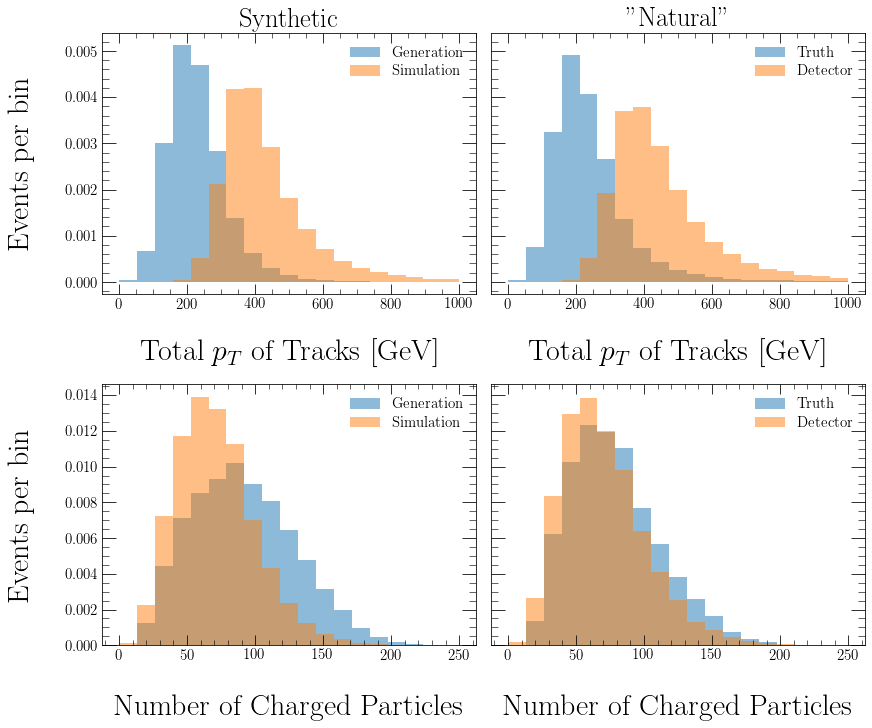

In [55]:
fig, ax = plt.subplots(2,
                       2,
                       figsize=(12, 10),
                       constrained_layout=True,
                       sharey='row')

bins = np.linspace(0, 1000, 20)

ax[0, 0].set_title('Synthetic')
ax[0, 0].set_xlabel('Total $p_T$ of Tracks [GeV]')
ax[0, 0].set_ylabel('Events per bin')
hG0, _, _ = ax[0, 0].hist(sum_pT_Tracks_0_G,
                          weights=weightsMC_0[mypass_0],
                          bins=bins,
                          
                          label='Generation', **plot_style_2)
hS0, _, _ = ax[0, 0].hist(sum_pT_Tracks_0_S,
                          weights=weightsMC_0[mypass_0],
                          bins=bins,
                          
                          label='Simulation', **plot_style_2)
legend = ax[0, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[0, 1].set_title('"Natural"')
ax[0, 1].set_xlabel('Total $p_T$ of Tracks [GeV]')
hG1, _, _ = ax[0, 1].hist(sum_pT_Tracks_unknown_G,
                          weights=weightsMC_unknown[mypass_unknown],
                          bins=bins,
                          
                          label='Truth', **plot_style_2)
hS1, _, _ = ax[0, 1].hist(sum_pT_Tracks_unknown_S,
                          weights=weightsMC_unknown[mypass_unknown],
                          bins=bins,
                          
                          label='Detector', **plot_style_2)
legend = ax[0, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

bins = np.linspace(0, 250, 20)

ax[1, 0].set_xlabel('Number of Charged Particles')
ax[1, 0].set_ylabel('Events per bin')
hG0, _, _ = ax[1, 0].hist(nTracks_0_G,
                          weights=weightsMC_0[mypass_0],
                          bins=bins,
                          
                          label='Generation', **plot_style_2)
hS0, _, _ = ax[1, 0].hist(nTracks_0_S,
                          weights=weightsMC_0[mypass_0],
                          bins=bins,
                          
                          label='Simulation', **plot_style_2)
legend = ax[1, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1, 1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1, 1].hist(nTracks_unknown_G,
                          weights=weightsMC_unknown[mypass_unknown],
                          bins=bins,
                          
                          label='Truth', **plot_style_2)
hS1, _, _ = ax[1, 1].hist(nTracks_unknown_S,
                          weights=weightsMC_unknown[mypass_unknown],
                          bins=bins,
                          
                          label='Detector', **plot_style_2)
legend = ax[1, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

fig.show()

### Define OmniFold Algorithm

In [56]:
"""    Arguments:
                            
        iterations: number of iterations (integer)
        
        theta_0_G: synthetic generation-level events 
                    (i.e. list of events with particles as 
                    (pT, eta, phi, charge)) as zero-padded Numpy array
                    
        theta_0_G: synthetic simulation-level events 
                    (i.e. list of events with particles as 
                    (pT, eta, phi, charge)) as zero-padded Numpy array
                    
        theta_unknown_S: "natural" (unknown) simulation-level  events 
                            (i.e. list of events with particles as 
                            (pT, eta, phi, charge))
                            to be unfolded as zero-padded Numpy array 
                            
        
        weightsMC_0: (optional) initial MC generator weights for synthetic sample
        
        weightsMC_unknown: (optional) initial MC generator weights for natural sample
        
        Returns:
        
        weights: A Numpy array of weights to reweight distribution of 
                    theta_0_G to the unfolded distribution of theta_unknown_S
        
        model: The model used to calculate those weights
"""


def omnifold(iterations,
             theta_0_G,
             theta_0_S,
             theta_unknown_S,
             weightsMC_0=None,
             weightsMC_unknown=None):

    if weightsMC_0 is None:
        weightsMC_0 = np.ones(len(theta_0_G))

    if weightsMC_unknown is None:
        weightsMC_unknown = np.ones(len(theta_unknown_S))

    labels_0 = np.zeros(len(theta_0_G))
    labels_unknown = np.ones(len(theta_unknown_S))

    xvals_1 = np.concatenate((theta_0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels_0, labels_unknown))

    xvals_2 = np.concatenate((theta_0_G, theta_0_G))
    yvals_2 = np.concatenate((labels_0, (labels_0 + 1.)))

    weights = np.empty(shape=(iterations, 2, len(theta_0_G)))
    # shape = (iteration, step, event)

    weights_pull = weightsMC_0
    weights_push = weightsMC_0

    # network architecture parameters
    Phi_sizes = (100, 100, 128)
    F_sizes = (100, 100, 100)

    model = PFN(input_dim=4,
                Phi_sizes=Phi_sizes,
                F_sizes=F_sizes,
                latent_dropout=0.2,
                F_dropouts=0.2,
                output_dim=1,
                output_act='sigmoid',
                summary=False)

    earlystopping = EarlyStopping(patience=5, restore_best_weights=True)

    print("Jumpstarting Model\n")
    count = 0
    while count < 20:
        count += 1

        X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(
            xvals_1, yvals_1)

        model.model.compile(loss='binary_crossentropy',
                            optimizer=keras.optimizers.Adam(),
                            metrics=['accuracy'])
        history = model.fit(X_train_1,
                            Y_train_1,
                            epochs=1,
                            batch_size=10000,
                            validation_data=(X_test_1, Y_test_1),
                            verbose=1)
        if (history.history['val_loss'][0] < history.history['loss'][0] - 0.1
            ) or history.history['val_loss'][0] < 1:
            break
        else:
            K.clear_session()

            model = PFN(input_dim=4,
                        Phi_sizes=Phi_sizes,
                        F_sizes=F_sizes,
                        latent_dropout=0.2,
                        F_dropouts=0.2,
                        output_dim=1,
                        output_act='sigmoid',
                        summary=False)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data
        print("STEP 1\n")

        weights_1 = np.concatenate((weights_push, weightsMC_unknown))
        # actual weights for Sim., initial MC for Data

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        #         print("Jumpstarting Model\n")
        #         count = 0
        #         while count < 20:
        #             count += 1

        #             model.model.compile(loss='binary_crossentropy',
        #                                 optimizer=keras.optimizers.Adam(),
        #                                 metrics=['accuracy'])
        #             history = model.fit(X_train_1,
        #                                 Y_train_1,
        #                                 sample_weight=w_train_1,
        #                                 epochs=1,
        #                                 batch_size=10000,
        #                                 validation_data=(X_test_1, Y_test_1, w_test_1),
        #                                 verbose=1)
        #             if (history.history['val_loss'][0] < history.history['loss'][0]) or history.history['val_loss'][0]<1:
        #                 break
        #             else:
        #                 reset_weights(model.model)

        #         print("Training Model\n")
        model.fit(X_train_1,
                  Y_train_1,
                  sample_weight=w_train_1,
                  epochs=200,
                  batch_size=1000,
                  validation_data=(X_test_1, Y_test_1, w_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(model, theta_0_S)
        weights[i, :1, :] = weights_pull

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((weightsMC_0, weights_pull))
        # initial MC for Gen., actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.model.compile(loss='binary_crossentropy',
                            optimizer='Adam',
                            metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  sample_weight=w_train_2,
                  epochs=200,
                  batch_size=1000,
                  validation_data=(X_test_2, Y_test_2, w_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = weightsMC_0 * reweight(model, theta_0_G)
        weights[i, 1:2, :] = weights_push

    return weights, model

### Unfold the Full Phase Space

In [57]:
weights, _ = omnifold(iterations=3,
                      theta_0_G=Tracks_0_G,
                      theta_0_S=Tracks_0_S,
                      weightsMC_0=weightsMC_0[mypass_0],
                      theta_unknown_S=Tracks_unknown_S,
                      weightsMC_unknown=weightsMC_unknown[mypass_unknown])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Jumpstarting Model

Train on 1143892 samples, validate on 381298 samples
Epoch 1/1
1143892/1143892 [==============================] - 561s 490us/step - loss: 5.6860 - acc: 0.5764 - val_loss: 0.6817 - val_acc: 0.5922

ITERATION: 1

STEP 1

Train on 1143892 samples, validate on 381298 samples
Epoch 1/200
1143892/1143892 [==============================] - 666s 582us/step - loss: 0.6887 - acc: 0.5902 - val_loss: 0.6853 - val_acc: 0.5916
Epoch 2/200
1143892/1143892 [==============================] - 665s 581us/step - loss: 0.6857 - acc: 0.5920 - val_loss: 0.6856 - val_acc: 0.5916
Epoch 3/200
1143892/1143892 [==============================] - 667s 583us/step - loss: 0.6868 - acc: 0.5918 - val_loss: 0.6852 - val_acc: 0.5916
Epoch 4/200
1143892/1143892 [==============================] - 667s 583us/step - loss: 0.6854 - acc: 0.5923 - val_loss: 0.6852 - val_acc: 0.5916
Epoch 5/200
1

1143892/1143892 [==============================] - 671s 587us/step - loss: 0.8392 - acc: 0.5085 - val_loss: 0.8297 - val_acc: 0.4094

STEP 2

Train on 933165 samples, validate on 311055 samples
Epoch 1/200
933165/933165 [==============================] - 524s 562us/step - loss: 0.8544 - acc: 0.5000 - val_loss: 0.8534 - val_acc: 0.5007
Epoch 2/200
933165/933165 [==============================] - 514s 551us/step - loss: 0.8527 - acc: 0.4998 - val_loss: 0.8534 - val_acc: 0.5007
Epoch 3/200
933165/933165 [==============================] - 521s 559us/step - loss: 0.8527 - acc: 0.4998 - val_loss: 0.8534 - val_acc: 0.5007
Epoch 4/200
933165/933165 [==============================] - 522s 559us/step - loss: 0.8526 - acc: 0.4998 - val_loss: 0.8533 - val_acc: 0.5007
Epoch 5/200
933165/933165 [==============================] - 522s 559us/step - loss: 0.8526 - acc: 0.4998 - val_loss: 0.8533 - val_acc: 0.5007
Epoch 6/200
933165/933165 [==============================] - 522s 559us/step - loss: 0.8526

ITERATION: 1


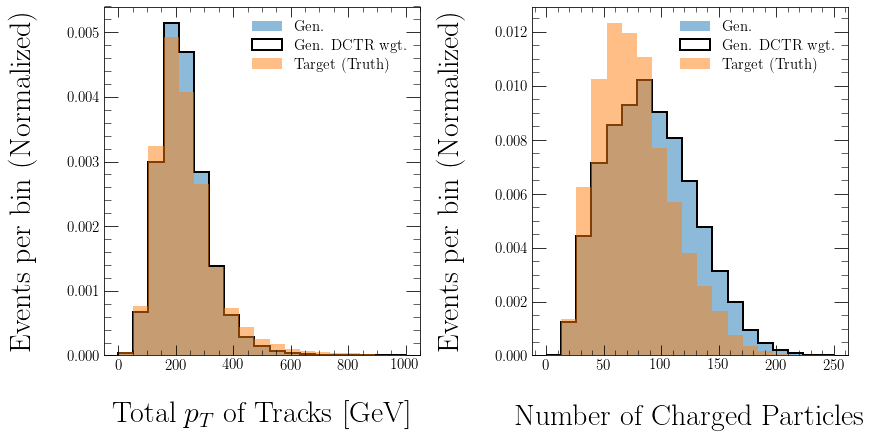

ITERATION: 2


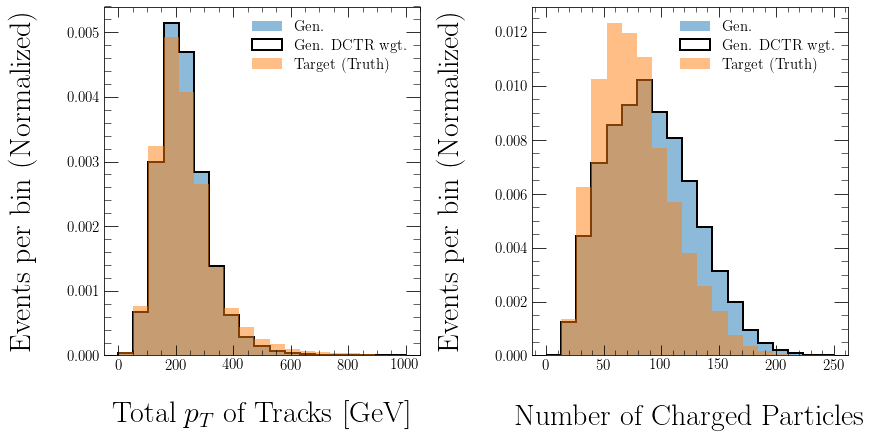

ITERATION: 3


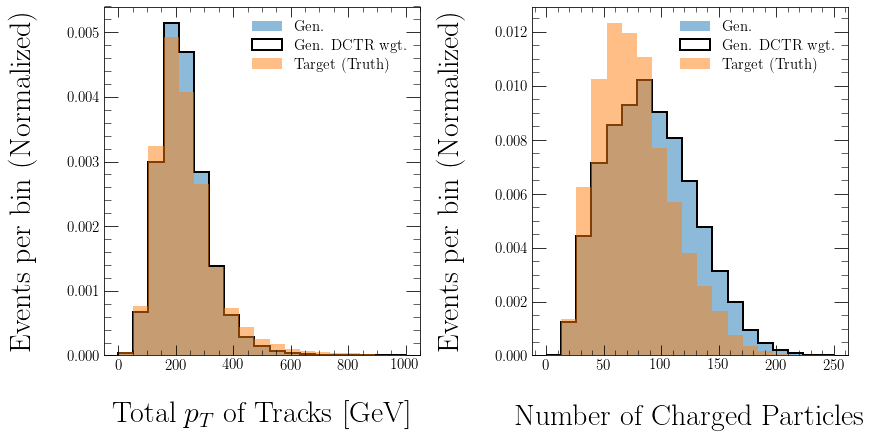

In [65]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(0, 1000, 20)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
    ax[0].set_xlabel('Total $p_T$ of Tracks [GeV]')
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(sum_pT_Tracks_0_G,
               weights=weightsMC_0[mypass_0],
               bins=bins,
               label=r'Gen.',
               **plot_style_2)
    ax[0].hist(sum_pT_Tracks_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)

    ax[0].hist(sum_pT_Tracks_unknown_G,
               weights=weightsMC_unknown[mypass_unknown],
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    ax[0].legend(frameon=False)

    bins = np.linspace(0, 250, 20)

    ax[1].set_xlabel('Number of Charged Particles')
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(nTracks_0_G,
               weights=weightsMC_0[mypass_0],
               bins=bins,
               label=r'Gen.',
               **plot_style_2)
    ax[1].hist(nTracks_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1].hist(nTracks_unknown_G,
               weights=weightsMC_unknown[mypass_unknown],
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    ax[1].legend(frameon=False)

    fig.show()
    plt.show()

ITERATION: 1


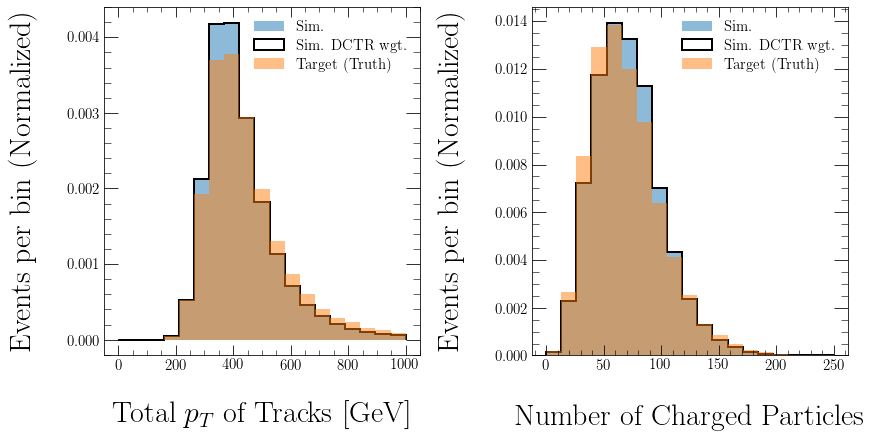

ITERATION: 2


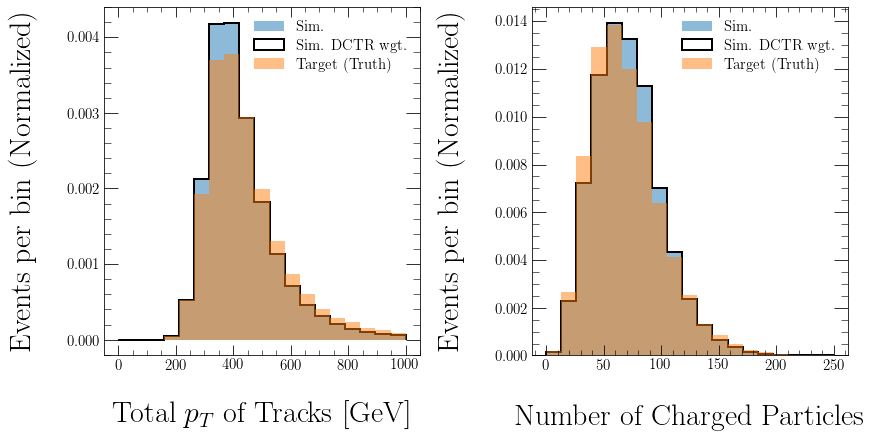

ITERATION: 3


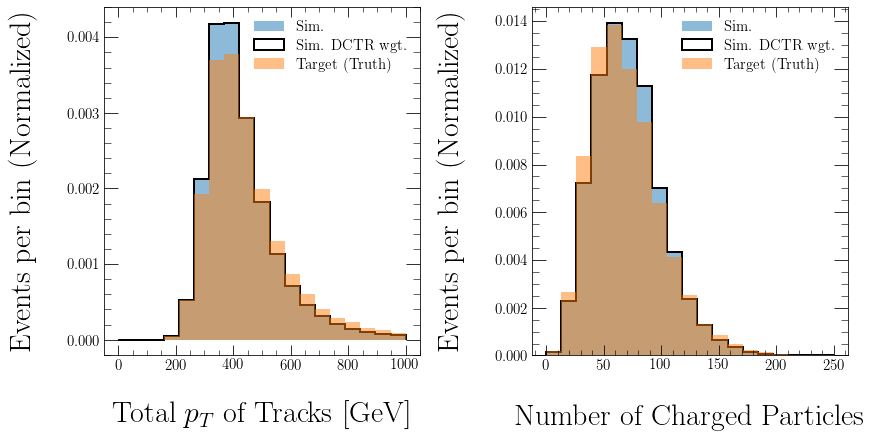

In [74]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(0, 1000, 20)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
    ax[0].set_xlabel('Total $p_T$ of Tracks [GeV]')
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(sum_pT_Tracks_0_S,
               weights=weightsMC_0[mypass_0],
               bins=bins,
               label=r'Sim.',
               **plot_style_2)
    ax[0].hist(sum_pT_Tracks_0_S,
               bins=bins,
               weights=weights[i, 0, :],
               label=r'Sim. DCTR wgt.',
               **plot_style_1)

    ax[0].hist(sum_pT_Tracks_unknown_S,
               weights=weightsMC_unknown[mypass_unknown],
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    ax[0].legend(frameon=False)

    bins = np.linspace(0, 250, 20)

    ax[1].set_xlabel('Number of Charged Particles')
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(nTracks_0_S,
               weights=weightsMC_0[mypass_0],
               bins=bins,
               label=r'Sim.',
               **plot_style_2)
    ax[1].hist(nTracks_0_S,
               bins=bins,
               weights=weights[i, 0, :],
               label=r'Sim. DCTR wgt.',
               **plot_style_1)
    ax[1].hist(nTracks_unknown_S,
               weights=weightsMC_unknown[mypass_unknown],
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    ax[1].legend(frameon=False)

    fig.show()
    plt.show()